## Research Lab: Political Polarization  - Visual Crawler Team

> Our task is to create an expert Twitter Crawler that monitors tweets to find posts that have images with matching faces of certain predefined politicians and then to grab replies to that tweet in order to find out how much hate that politician reveive within the Twitter. These results can then result in an index to show how popular or infamous a politician is on socail media.


Our base data set consists of 4 World Powers ( Mr Donald Trump, Mr Valdimir Putin, Mrs. Angela Merkel and Mr Bouris Johnson). We have 3 images of each and each tweet that includes images will be checked against all the photos.

We use a mixture of different techniques to take advantage of Tweeter API. On average, 10 percent of the collected tweets have images. Out of these, usually 2.1 percent are original tweets (from the news channels amd not re-tweets) and have detectable images of our politicians dataset. For these tweets we use a second api called TWARC to just grab related replies. This process is very slow and requires more access keys and process power to work for larger scales. Last but not least, all the replies will be checked to see any cases hate speech is occuring. We have found out that there is at least 5.3 percent of hate speech involved in the politicians' tweets which we call observable hate since it is the amount a machine learning algorithm can detect.


In [1]:
import os
import sys
import pandas as pd
import yaml
import matplotlib.pyplot as plt

parameters = {}
with open("../parameters.yml", 'r') as stream:
    try:
        parameters = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

csvFile = '../src/data/processed/' + parameters['parsed_file']
tweets = pd.read_csv(csvFile, sep=',')


repliesCsvFile = '../src/data/processed/' + parameters['reply_file']
replies = pd.read_csv(repliesCsvFile, sep=',')

dataCsvFile = '../src/data/classes/' + parameters['class_name'] + '/' + 'index.csv'
data = pd.read_csv(dataCsvFile, sep='\t')
data = data.append({'name': 'other', 'token': 'other', 'tags': ''}, ignore_index=True)

### A- Comparing hate received by each politician:

In [2]:
data['tweets'] = 0
data['replies'] = 0
data['auto_hate'] = 0 # requires better algorithms
data['ah_ratio'] = 0
data['hate_ratio'] = 0
data['manual_hate'] = 0 # waiting for manual data


for index, element in tweets.iterrows():
    vote = str(element['vote'])
    found = []
    if 'nan' == vote:
        continue
    if '0.0' != vote: 
        # detected politicians:
        politicians = element['matches'].split("####")
        for politician in politicians:
            for position, datum in data.iterrows():
                if politician.startswith(datum['token']):
                    if politician in found:
                        continue
                    data.loc[position, 'tweets'] = data.loc[position, 'tweets'] + 1
                    found.append(politician)
                    # check replies
                    tempest_replies = replies.loc[replies['tweet_id'] == element['tweet_id']]
                    data.loc[position, 'replies'] = data.loc[position, 'replies'] + len(tempest_replies)
                    # check hates
                    tempest_hate = tempest_replies.loc[tempest_replies['automatic'] == 1]
                    data.loc[position, 'auto_hate'] = data.loc[position, 'auto_hate'] + len(tempest_hate)
                    
                    break
    if [] == found:
        last = len(data)-1
        data.loc[last, 'tweets'] = data.loc[last, 'tweets'] + 1

### Snapshot of received hate:

To what extent replies of a politician a hate messages

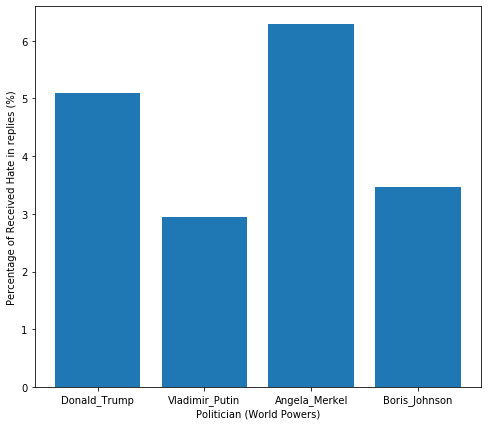

In [3]:
for position, datum in data.iterrows():
    if 0 == datum['replies']:
        data.loc[position, 'ah_ratio'] = 0
    else:
        data.loc[position, 'ah_ratio'] = (datum['auto_hate']/datum['replies']) * 100 

tempData = data.drop([len(data)-1], axis=0) 
tempData['nah_ratio'] = 100 - tempData['ah_ratio']

# plot a bar chart of hate percentages:
plt.figure(figsize=(8,7))
plt.bar(tempData['token'], tempData['ah_ratio'])
plt.xlabel('Politician (World Powers)')
plt.ylabel('Percentage of Received Hate in replies (%)')
plt.show()
        

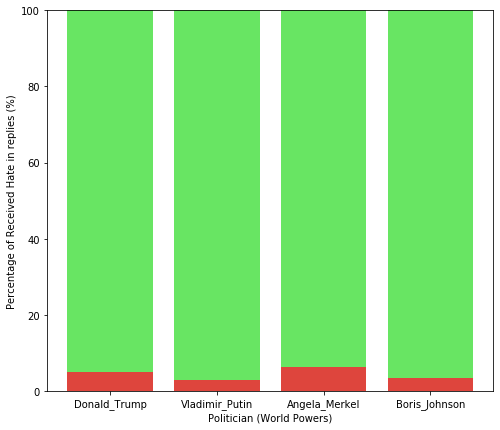

In [4]:
# real impression plot:
plt.figure(figsize=(8,7))
plt.bar(tempData['token'], tempData['ah_ratio'], color='#de453d')
plt.bar(tempData['token'], tempData['nah_ratio'], bottom=tempData['ah_ratio'], color='#68e563')
plt.xlabel('Politician (World Powers)')
plt.ylabel('Percentage of Received Hate in replies (%)')
plt.ylim(0, 100)
plt.show()

### Hate Share:

Which politician received more hate in a fraction of Twitter Stream

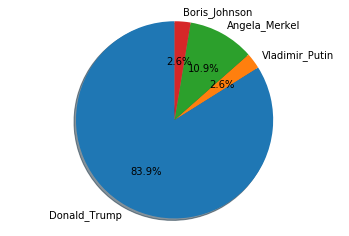

In [5]:
total = data['auto_hate'].sum()

for position, datum in data.iterrows():
    if 0 == datum['replies']:
        data.loc[position, 'hate_ratio'] = 0
    else:    
        data.loc[position, 'hate_ratio'] = (datum['auto_hate']/total) * 100 

tempData = data.drop([len(data)-1], axis=0) 

#plot as pie

fig1, ax1 = plt.subplots()
ax1.pie(tempData['hate_ratio'],  labels=tempData['token'], autopct='%1.1f%%',
        shadow=True, startangle=90,)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### B- Accuracy of Face Recognition?

### C- Accuracy of Hate Votes?

### D- Location-based Hate:


We divided cases of hate speech into 2 categories of in USA and out of USA. It is worth mentioning that because of data protection policies it is possible to hide or change geographical description of the twitter account. 

Regardless, we are comparing the fraction of hate speech `Mr. Donald Trump` has received from user_locations that are inside USA and out of USA.

Our decision is based on the following:

is_usa is true when: `USA`, `U.S.A.`, `United States` and state codes: ` ('AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR,PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY')`

In [6]:
locations = {'h_in': 0, 'total_in': 0, 'h_out': 0, 'total_out': 0}
is_usa = ['USA', 'U.S.A.', 'United States', 
          'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA',
          'KS','KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ',
          'NM','NY','NC','ND','OH','OK','OR,PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

# just grab Donald Trump:
for index, element in tweets.iterrows():
    vote = str(element['vote'])
    found = []
    if 'nan' == vote:
        continue
    if '0.0' != vote: 
        # detected politicians:
        politicians = element['matches'].split("####")
        for politician in politicians:
            for position, datum in data.iterrows():
                if politician.startswith(datum['token']):
                    if politician in found:
                        continue
                    # only trump is considered here
                    if 'Donald_Trump' != datum['token']:
                        continue
                    # we do not want to repeat a politician many times    
                    found.append(datum['token'])
                    tempest_replies = replies.loc[replies['tweet_id'] == element['tweet_id']]
                    for pos, tempest_reply in tempest_replies.iterrows():
                        checker = False
                        was_hate = False
                        if 1 == tempest_reply['automatic']:
                            was_hate = True
                        
                        for locality in is_usa:
                            my_location = str(tempest_reply['user_location'])
                            if locality in my_location:
                                locations['total_in'] = locations['total_in'] + 1
                                if was_hate:
                                    locations['h_in'] = locations['h_in'] + 1
                                checker = True
                                break
                        if not checker: 
                            locations['total_out'] = locations['total_out'] + 1
                            if was_hate:
                                locations['h_out'] = locations['h_out'] + 1
                    break

In [7]:
print (locations)

{'h_in': 58, 'total_in': 1147, 'h_out': 135, 'total_out': 2645}


### Share of Donald Trump's replies 

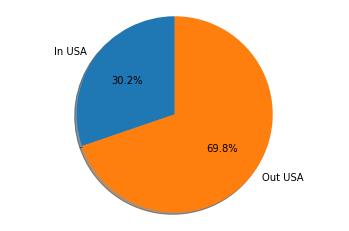

In [8]:
#plot as pie
fig1, ax1 = plt.subplots()
ax1.pie([locations['total_in'], locations['total_out']],  labels=['In USA', 'Out USA'], autopct='%1.1f%%',
        shadow=True, startangle=90,)
ax1.axis('equal')

plt.show()

### Comparing Hatred in US and out of US

Trump is hated equally inside and outside of USA.

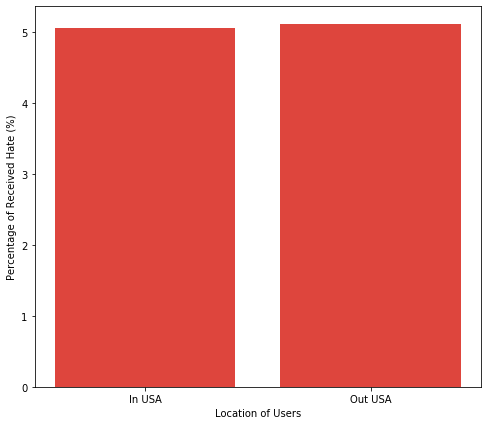

In [9]:
in_usa_percentage = (locations['h_in']/locations['total_in']) * 100
out_usa_percentage = (locations['h_out']/locations['total_out']) * 100

plt.figure(figsize=(8,7))
plt.bar(['In USA', 'Out USA'], [in_usa_percentage, out_usa_percentage], color='#de453d')
# plt.bar(tempData['token'], tempData['nah_ratio'], bottom=tempData['ah_ratio'], color='#68e563')
plt.xlabel('Location of Users')
plt.ylabel('Percentage of Received Hate (%)')
plt.show()

### Known Challenges or issues:


- Accuracy of hatespeech and face recognition algorithms.


- Collecting replies to a comment is very time consuming.


- Detecting replies that come in GIFs or image memes.


- Considering unique users behind the comments. Wegihting comments based on number of followers and detecting whom hate speech is actually targetting.


- Maybe politicians are not hated this much and it is just the very short time span that we have monitored Twitter.

- One tweet may include multiple politicians at once. (and more strangely one politician multiple times)


- Confirmation Bias exists.